In [ ]:
!pip install torchtext==0.8.0 torch==1.11.0 pytorch-lightning==1.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
#from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
import os 
from sklearn.model_selection import train_test_split

In [ ]:
image_path = '/content/drive/MyDrive/2022 1/IA2/Labs/datasets/Dataset_basura/'
directorio = os.listdir(image_path) 
directorio

['metales',
 'botellas_de_plastico',
 'cartones',
 'Plastoformos',
 'BolsasPlasticas',
 'papel']

In [ ]:
clases = {'metales':0, 'botellas_de_plastico':1, 'papel':2, 'cartones':3, 'Plastoformos':4, 'BolsasPlasticas':5} 
clases

{'BolsasPlasticas': 5,
 'Plastoformos': 4,
 'botellas_de_plastico': 1,
 'cartones': 3,
 'metales': 0,
 'papel': 2}

In [ ]:
imgs, labels = [], []
size = 32
for img in directorio: # recorremos elcorchetes direcotior
  imagenes = os.listdir(image_path + img)
  #print(paths)
  for i in imagenes:
    dir_imagenes = image_path + img + '/' + i #
    #print(dir_imagenes)
    open_images = Image.open(dir_imagenes).convert('RGB')
    resize_image = open_images.resize((size, size)) 
    imgs.append(np.array(resize_image)/255)
    #print(img_array)
    labels.append(clases[img])
  

In [ ]:
imgs = np.asarray(imgs)
imgs.shape

(5897, 32, 32, 3)

In [ ]:
# redimencionamos las imagenes 
dimension = (imgs.shape[1] * imgs.shape[2]*imgs.shape[3])
#print(dimension.shape)
#print(dimension.dtype)
imgs = imgs.reshape(imgs.shape[0], dimension)

In [ ]:
imgs.shape

(5897, 3072)

In [ ]:
labels = np.asarray(labels)
labels

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
print(imgs.dtype) 
print(labels.dtype) 

float64
int64


In [ ]:
imgs.shape, labels.shape

((5897, 3072), (5897,))

In [ ]:
labels.shape

(5897,)

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X 
    self.y = y 

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float().view(3, 32, 32), torch.tensor(self.y[ix]).long()
    
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        #fmnist = fetch_openml("Fashion-MNIST", version=1)
        X, y = imgs, labels
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
        self.train_ds = Dataset(X_train, y_train)
        self.val_ds = Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [ ]:
dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

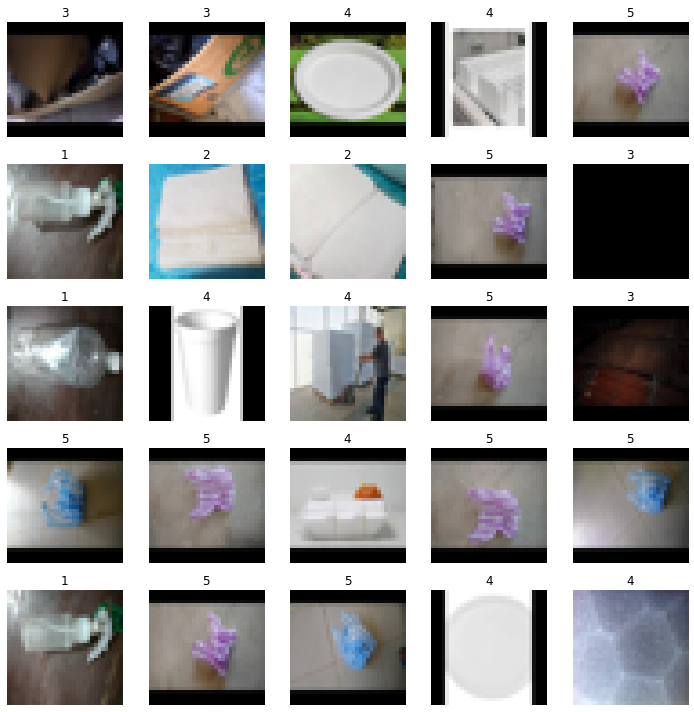

In [ ]:
r, c = 5, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(32, 32, 3))
        ax.set_title(label.item())
plt.tight_layout()
plt.show()

## El modelo

Empezamos con la implementación del *patch embedding*. Este módulo recibirá un batch de imágenes y se encargará de proyectar los diferentes *patches*. Para ello podemos usar una capa convolucional con un tamaño de *kernel* y *stride* iguales al tamaño del *patch* que queramos usar.

import torch.nn as nn



In [ ]:
import torch.nn as nn

# https://github.com/jankrepl/mildlyoverfitted/blob/master/github_adventures/vision_transformer/custom.py

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

In [ ]:
pe = PatchEmbedding(32, 7, 3, 100)
out = pe(imgs)
out.shape

torch.Size([64, 16, 100])

In [ ]:
import math

class MultiHeadAttention(nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads 
        
        # key, query, value projections
        self.key = nn.Linear(n_embd, n_embd*n_heads)
        self.query = nn.Linear(n_embd, n_embd*n_heads)
        self.value = nn.Linear(n_embd, n_embd*n_heads)
        
        # output projection
        self.proj = nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        
        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L) 
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side
        
        return self.proj(y)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )
        
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [ ]:
class ViT(nn.Module):

    def __init__(self, img_size=32, patch_size=7, in_chans=3, embed_dim=100, n_heads=3, n_layers=3, n_classes=6):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        
        self.tranformer = torch.nn.Sequential(*[TransformerBlock(embed_dim, n_heads) for _ in range(n_layers)])
        
        self.ln = nn.LayerNorm(embed_dim)
        self.fc = torch.nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        e = self.patch_embed(x)
        B, L, E = e.size()
        
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, E)
        e = torch.cat((cls_token, e), dim=1)  # (B, 1 + N, E)
        e = e + self.pos_embed  # (B, 1 + N, E)
        
        z = self.tranformer(e)
        
        cls_token_final = z[:, 0]  
        y = self.fc(cls_token_final)

        return y

In [ ]:
vit = ViT()
out = vit(imgs)
out.shape

torch.Size([64, 6])

In [ ]:
class Model(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.vit = ViT()

    def forward(self, x):
        return self.vit(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)
        
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
        return optimizer

In [ ]:
model = Model()
out = model(imgs)
out.shape

torch.Size([64, 6])

In [ ]:
model = Model()
trainer = pl.Trainer(max_epochs=5, gpus=0, logger=None)
trainer.fit(model, dm)

GPU available: False, used: False
GPU available: False, used: False
TPU available: None, using: 0 TPU cores
TPU available: None, using: 0 TPU cores

  | Name | Type | Params
------------------------------
0 | vit  | ViT  | 623 K 
------------------------------
623 K     Trainable params
0         Non-trainable params
623 K     Total params
2.492     Total estimated model params size (MB)

  | Name | Type | Params
------------------------------
0 | vit  | ViT  | 623 K 
------------------------------
623 K     Trainable params
0         Non-trainable params
623 K     Total params
2.492     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

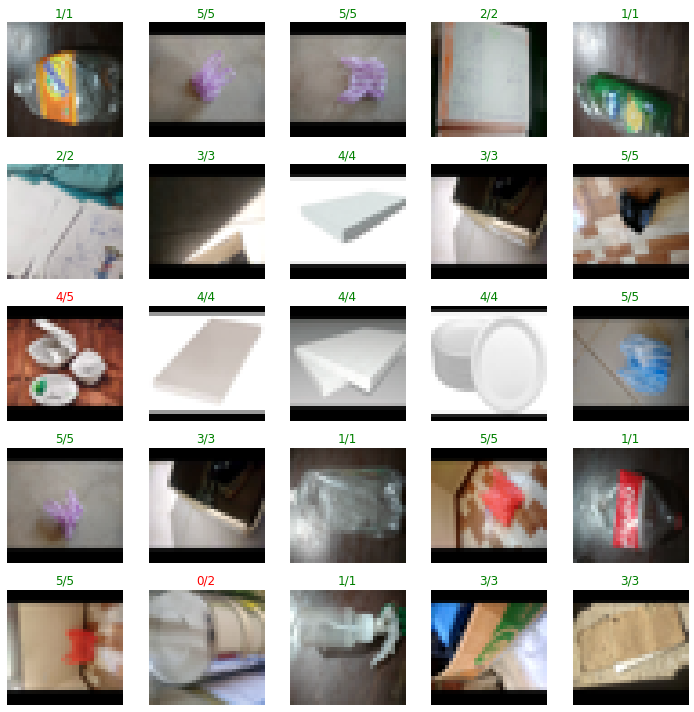

In [ ]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = model.predict(imgs)

r, c = 5, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(32,32,3))
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

#{'BolsasPlasticas': 5, 'Plastoformos': 4, 'botellas_de_plastico': 1, 'cartones': 3, 'metales': 0, 'papel': 2}
